In [ ]:
Lendo os dados. Cada conjunto aqui sera uma view que sera utilizada para construir uma matriz de dissimilaridade
Euclidiana. No total, serao 3 matrizes de dissimilaridade, todas com a mesma métrica (distância Euclidiana) mas
uma para cada view.

In [3]:
import math
import numpy as np
import pandas as pd

dfac = pd.read_csv('dados/mfeat-fac', delim_whitespace=True, header=None)
dfou = pd.read_csv('dados/mfeat-fou', delim_whitespace=True, header=None)
dkar = pd.read_csv('dados/mfeat-kar', delim_whitespace=True, header=None)

In [ ]:
Calculando as matrizes de dissimilaridade para cada view.

In [4]:
from sklearn.metrics.pairwise import euclidean_distances

dfac_matrix = euclidean_distances(dfac, dfac)
dfou_matrix = euclidean_distances(dfou, dfou)
dkar_matrix = euclidean_distances(dkar, dkar)
dist_matrixes = np.asarray([dfac_matrix, dfou_matrix, dkar_matrix])

In [ ]:
Segundo a documentaçao do scikit-learn, em algumas situacoes, por questoes de precisao, a matriz pode nao ser
exatamente simetrica. Portanto, estou checando se cada matriz gerada e simetrica dentro de uma tolerancia de erro
de 1e-8.

In [5]:
import numpy as np

print(np.allclose(dfac_matrix, dfac_matrix.T, atol=1e-8))
print(np.allclose(dfou_matrix, dfou_matrix.T, atol=1e-8))
print(np.allclose(dkar_matrix, dkar_matrix.T, atol=1e-8))

True
True
True


In [ ]:
As matrizes geradas sao simetricas.

In [ ]:
Inicializando agora as variaveis/parametros do algoritmo. Assumindo versao MFCMdd-RWG-S do algoritmo, onde os pesos
de cada matriz de dissimilaridade devem somar 1.

In [86]:
# PARAMETROS
# Numero de clusters
K = 10
# Parametro m
m = 1.6
# Parametro s
s = 1
# Parametro q
q = 3
# Numero fixo de iteracoes (retira a necessidade da checagem de estagnacao do algoritmo)
T = 100

# VARIAVEIS
# Peso de relevancia para cada view - MFCMdd-RWG-S
lambdas = np.asarray([1.0] * len(dist_matrixes))
# Prototipos - Prototipos sao representados por indices (numero da linha nas matrizes de dissimilaridade)
prototypes = []
for i in range(0, K):
    prototypes.append(np.random.randint(len(dfac_matrix), size=q))
prototypes = np.asarray(prototypes)

In [ ]:
Implementando a funcao para calcular o grau de pertinencia de um elemento i (element_index) para o cluster k
(cluster_index).

In [57]:
def membership_degree(element_index, cluster_index, lambdas, prototypes, dist_matrixes, s, m):
    final_sum = 0
    
    numerator = 0
    for j, lambda_v in enumerate(lambdas):
        distances_sum = 0
        distance_matrix = dist_matrixes[j]
        for prot_element_index in prototypes[cluster_index]:
            distances_sum += distance_matrix[element_index][prot_element_index]
        numerator += pow(lambda_v, s) * distances_sum
    
    for h, prototype in enumerate(prototypes):        
        denominator = 0
        for j, lambda_v in enumerate(lambdas):
            distances_sum = 0
            distance_matrix = dist_matrixes[j]
            for prot_element_index in prototype:
                distances_sum += distance_matrix[element_index][prot_element_index]
            denominator += pow(lambda_v, s) * distances_sum
        final_sum += pow(numerator / denominator, 1.0 / (m - 1))
    
    return pow(final_sum, -1)

In [ ]:
Implementando funçao que atualiza os graus de pertinencia de cada elemento para cada cluster fuzzy.

In [58]:
def update_membership_degrees(lambdas, prototypes, dist_matrixes, s, m):
    membership_degrees = []
    for i in range(0, len(dist_matrixes[0])):
        new_line = []
        for k in range(0, len(prototypes)):
            new_line.append(membership_degree(i, k, lambdas, prototypes, dist_matrixes, s, m))
        new_line = np.asarray(new_line)
        membership_degrees.append(new_line)
    return np.asarray(membership_degrees)

In [ ]:
Implementando funcao que calcula a adequaçao do agrupamento (funcao objetivo que e minimizada).

In [59]:
def calculate_adequacy_criterion(membership_degrees, lambdas, prototypes, dist_matrixes, s, m):
    final_sum = 0
    for k, prototype in enumerate(prototypes):
        sum2 = 0
        for i, membership_degree in enumerate(membership_degrees):
            sum1 = 0
            for j, lambda_v in enumerate(lambdas):
                distances_sum = 0
                distance_matrix = dist_matrixes[j]
                for prot_element_index in prototype:
                    distances_sum += distance_matrix[i][prot_element_index]
                sum1 += pow(lambda_v, s) * distances_sum
            sum2 += pow(membership_degree[k], m) * sum1
        final_sum += sum2
    return final_sum

In [ ]:
Inicializando matriz de graus de pertinencia de cada elemento para cada cluster com zeros e calculando valores
iniciais.

In [87]:
membership_degrees_matrix = update_membership_degrees(lambdas, prototypes, dist_matrixes, s, m)

In [ ]:
Visualizando a matriz de graus de pertinencia de cada elemento a cada cluster em um heatmap. Abaixo do heatmap
fuzzy, encontra-se um heatmap exibindo uma visualizaçao dos mesmos dados em hard clustering, onde o grau de
pertinencia mais alto de cada elemento na matriz de graus de pertinencia foi considerado o indicador do cluster
ao qual o elemento pertence. Branco significa pertencimento, preto significa nao pertencimento.

[[ 0.12143329  0.0821186   0.09055965 ...,  0.08949267  0.13724854
   0.17454518]
 [ 0.11667053  0.08024184  0.09051081 ...,  0.08825093  0.14353477
   0.16730295]
 [ 0.12414316  0.0831265   0.08810776 ...,  0.09071355  0.13828653
   0.17334638]
 ..., 
 [ 0.10077664  0.07015105  0.15897889 ...,  0.10310359  0.08619051
   0.15179429]
 [ 0.09457871  0.07229436  0.14221325 ...,  0.09431547  0.09937648
   0.1449295 ]
 [ 0.08778578  0.06690199  0.1921013  ...,  0.10820783  0.08085098
   0.11374067]]


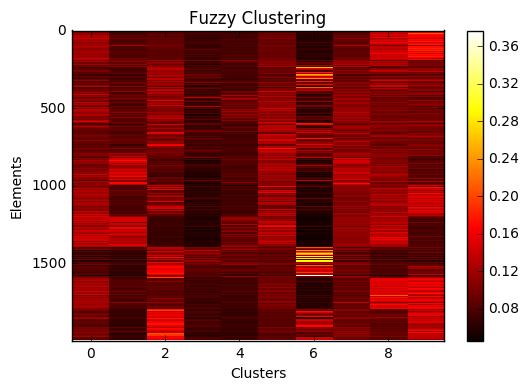

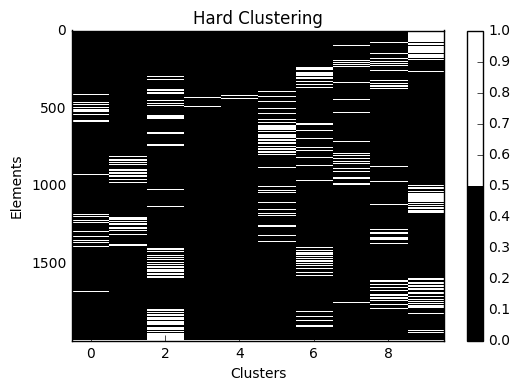

In [88]:
import matplotlib.pyplot as plt
import matplotlib as mpl

print(membership_degrees_matrix)
plt.imshow(membership_degrees_matrix, cmap='hot', interpolation='nearest', aspect='auto',)
plt.ylabel('Elements')
plt.xlabel('Clusters')
plt.title("Fuzzy Clustering")
plt.colorbar()
plt.show()

hard_clustering_matrix = np.zeros_like(membership_degrees_matrix)
hard_clustering_matrix[np.arange(len(membership_degrees_matrix)), membership_degrees_matrix.argmax(1)] = 1
plt.imshow(hard_clustering_matrix, cmap=mpl.colors.ListedColormap(['k', 'w']), interpolation='nearest', aspect='auto')
plt.ylabel('Elements')
plt.xlabel('Clusters')
plt.title('Hard Clustering')
plt.colorbar()
plt.show()

In [ ]:
Checando se a soma dos graus de pertinencia de cada individuo e 1 com tolerancia de 1e-8 de diferenca, dados os
erros de arredondamento. Resultados estao coerentes com a restricao de soma.

In [89]:
print(np.allclose(sum(membership_degrees_matrix.T), np.array([[1] * len(membership_degrees_matrix)]), atol=1e-8))

True


In [ ]:
Calculando o valor da funcao objetivo a ser minimizada.

In [90]:
J = calculate_adequacy_criterion(membership_degrees_matrix, lambdas, prototypes, dist_matrixes, s, m)
print(J)

2113531.24339


In [ ]:
A partir daqui, 3 passos serao intercalados ate um dado numero da iteracoes ser atingido: Definicao dos melhores
prototipos, calculo dos pesos das matrizes de dissimilaridade e calculo da matriz dos graus de pertinencia. A
ultima funcao ja esta implementada, restando a implementacao das duas primeiras.

In [ ]:
Implementando funcao de definicao dos melhores prototipos.

In [64]:
def define_prototypes(membership_degrees_matrix, lambdas, dist_matrixes, s, m):
    prototypes = []
    for k in range(0, K):
        new_prototype = []
        for q_counter in range(0, q):
            min_value = float("inf")
            min_index = -1
            for h in range(0, len(membership_degrees_matrix)):
                total_sum = 0
                for i in range(0, len(membership_degrees_matrix)):
                    distances_sum = 0
                    for j, lambda_v in enumerate(lambdas):
                        distances_sum += pow(lambda_v, s) * dist_matrixes[j][i][h]
                    total_sum += pow(membership_degrees_matrix[i][k], m) * distances_sum
                if total_sum < min_value and h not in new_prototype:
                    min_value = total_sum
                    min_index = h
            new_prototype.append(min_index)
        new_prototype = np.asarray(new_prototype)
        prototypes.append(new_prototype)
    return np.asarray(prototypes)

In [ ]:
Testando rapidamente a funcao de definicao de prototipos.

In [28]:
new_prototypes = define_prototypes(membership_degrees_matrix, lambdas, dist_matrixes, s, m)
print(new_prototypes)

[[ 692  554 1025]
 [ 692 1773 1784]
 [ 692  566  685]
 [ 554  692  436]
 [ 566  692 1910]
 [ 692  566  460]
 [ 692  554 1784]
 [ 554  692 1773]
 [ 692  566  600]
 [ 692 1773  554]]


In [ ]:
Implementando funcao de update dos lambdas.

In [65]:
def calculate_lambda(matrix_index, membership_degrees_matrix, prototypes, dist_matrixes, s, m):
    denominator = 0
    for k in range(0, K):
        sum1 = 0
        for i in range(0, len(membership_degrees_matrix)):
            distances_sum = 0
            distance_matrix = dist_matrixes[matrix_index]
            for prot_element_index in prototypes[k]:
                distances_sum += distance_matrix[i][prot_element_index]
            sum1 += pow(membership_degrees_matrix[i][matrix_index], m) * distances_sum
        denominator += sum1
    
    produtorio = 1    
    for h in range(0, len(dist_matrixes)):
        sum_ = 0
        for k in range(0, K):
            for i in range(0, len(membership_degrees_matrix)):
                distances_sum = 0
                distance_matrix = dist_matrixes[h]
                for prot_element_index in prototypes[k]:
                    distances_sum += distance_matrix[i][prot_element_index]
                sum_ += pow(membership_degrees_matrix[i][matrix_index], m) * distances_sum
        produtorio *= pow(sum_, 1.0 / len(dist_matrixes))
    
    return produtorio / denominator

In [66]:
def update_lambdas(membership_degrees, prototypes, dist_matrixes, s, m):
    new_lambdas = []
    for j in range(0, len(lambdas)):
        new_lambdas.append(calculate_lambda(j, membership_degrees, prototypes, dist_matrixes, s, m))
    return np.asarray(new_lambdas)

In [ ]:
Testando rapidamente a funcao de atualizacao dos lambdas e checando se o seu produto é aproximadamente 1.

In [33]:
new_lambdas = update_lambdas(membership_degrees_matrix, prototypes, dist_matrixes, s, m)
print(np.prod(new_lambdas))

1.00312001403


In [ ]:
Colocaremos agora as operacoes executando de maneira intercalada dentro de iteracoes. Lembrando que, de acordo
com a especificacao do projeto, terei que executar fixas 100 iteracoes, e nao parar quando o erro atingir
um determinado valor. Estou fazendo 1/5 da execucao por vez para ter checkpoints (isso vai demorar mto).

In [91]:
J_values_over_time = []
lambdas_over_time = []
membership_degrees_matrix_over_time = []

In [ ]:
for t in range(0, int(T / 5)):
    print('Iteracao: ' + str(t) + ' - Adequacao: ' + str(J) + ' - Produto lambdas: ' + str(np.prod(new_lambdas)))
    prototypes = define_prototypes(membership_degrees_matrix, lambdas, dist_matrixes, s, m)
    lambdas = update_lambdas(membership_degrees_matrix, prototypes, dist_matrixes, s, m)
    membership_degrees_matrix = update_membership_degrees(lambdas, prototypes, dist_matrixes, s, m)
    J = calculate_adequacy_criterion(membership_degrees_matrix, lambdas, prototypes, dist_matrixes, s, m)
    J_values_over_time.append(J)
    lambdas_over_time.append(lambdas)
    membership_degrees_matrix_over_time.append(membership_degrees_matrix)

Iteracao: 0 - Adequacao: 2113531.24339 - Produto lambdas: 1.00312001403
